# Setup

In [1]:
import nltk
import os
import time
import numpy as np
from pathlib import Path
from dataset import Dataset
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import load_model

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Dataset Load

690 lines skipped (not labeled)
0 lines skipped (not text)
Text Length Max:  104
Text Length Min:  1
Text Length Mode: 7
Text Length Mean: 9.00
Text Length Std:  4.73
S/W Text Ratio:   9.00


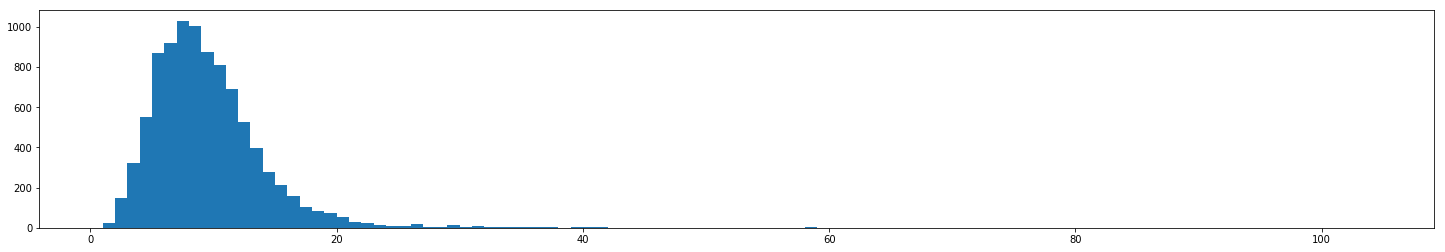

In [2]:
filename = 'datasets/amazon_co-ecommerce_sample.csv'
text_field = 'name'

dataset = Dataset(filename)
dataset.load(text_field=text_field, label_field='category')
dataset.text_info()

# Preprocessing

In [3]:
tokenizer = dataset.tokenize()
label_encoder = dataset.label_encode()

Number of Tokens: 13363


In [4]:
data_train, data_test = train_test_split(dataset.data, test_size=0.1)
    
token_train = tokenizer.texts_to_sequences(data_train.text)
text_train = pad_sequences(token_train, maxlen=dataset.max_text())
label_train = label_encoder.transform(data_train.label)
        
token_test = tokenizer.texts_to_sequences(data_test.text)
text_test = pad_sequences(token_test, maxlen=dataset.max_text())
label_test = label_encoder.transform(data_test.label)

# Load Model

In [ ]:
PATH_MODELS = 'created_models/'
MODEL = PATH_MODELS + 'lstm_jatana_name.h5'

In [ ]:
model = load_model(MODEL)

/anaconda2/envs/CnnEnv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Train Model

In [ ]:
tensorboard = TensorBoard(log_dir="logs/" + model.name + '(' + time.asctime() + ')')

In [ ]:
earlyStopping = EarlyStopping(monitor='val_acc', mode='auto',
                              min_delta=0.01, patience=5)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
hist = model.fit(text_train, label_train, 
                 batch_size=32, epochs=60, initial_epoch=0,
                 verbose=1, callbacks=[earlyStopping, tensorboard],
                 validation_split=0.1)

Train on 7541 samples, validate on 838 samples
Epoch 1/60
2624/7541 [=========>....................] - ETA: 42s - loss: 4.5059 - acc: 0.0865

# Evaluation

### Metrics

In [ ]:
ev_test  = model.evaluate(text_test, label_test, verbose=1)
label_pred = np.argmax(model.predict(text_test),axis=1)
label_pred = label_encoder.inverse_transform(label_pred)

In [ ]:
acc_tr   = hist.history['acc'][-1]
loss_tr  = hist.history['loss'][-1]
acc_val  = hist.history['val_acc'][-1]
loss_val = hist.history['val_loss'][-1]
acc_te   = ev_test[1]
loss_te  = ev_test[0]

print('Train)      Acc:', round((100*acc_tr),2),  'Loss:', round((loss_tr),3))
print('Validation) Acc:', round((100*acc_val),2), 'Loss:', round((loss_val),3))
print('Test)       Acc:', round((100*acc_te),2),  'Loss:', round((loss_te),3))

### Classification Report

**Precision** is the percentage of samples correctly predicted to that category<br>
P = tp / (tp + fp), tp = true positive, fp = false positive <br><br>

**Recall** is the percentage of samples of that category predicted correctly<br>
R    = tp / (tp + fn), tp = true positive, fn = false Negative <br><br>

In [ ]:
class_report = metrics.classification_report(label_test, label_pred)
split = class_report.split('\n')
for i, line in enumerate(split):
    s = line.split()
    if len(s) > 0:
        support   = s[-1]
        s.pop()
        f1_score  = s[-1]
        s.pop()
        recall    = s[-1]
        s.pop()
        precision = s[-1]
        s.pop()
        if len(s) <= 0:
            label = 'label'
        else:
            label = ' '.join(s)
        split[i] = [label, precision, recall, f1_score, support]
    else:
        split[i] = ['']

df = pd.DataFrame(split)
df.columns = df.loc[0]
df = df.drop([0])
df = df.dropna()

In [ ]:
print('Classification Report')
df[-10:]

# Save Trained Model

In [ ]:
# Save Model
model.save('trained_models/' + model.name + '.h5'))